In [1]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot

# ABSTRACT

Este miniproyecto consta de dos finalidades, la primera la utilización de la librería plotly para la visualización de datos, sobretodo relacionados con el ámbito financiero,así como su version simplificada llamada plotly express.La segunda el estudio de series de tiempo con los nuevos algoritmos Prophet y Neural Prophet que proceden de la compañía Facebook para ver su highlights en el código y además de su desempeño en la prediccion.

Para ello se van a utilizar dos datasets distintos:

El primero es la cotizacion de la acción de apple en el mercado S&P500 desde 2006 hasta 2017
El segundo es la temperatura de una ciudad seleccionada de USA (Los Angeles) entre 2012 y 2017 en periodos de una hora.

Como se va a ver en los resultados no es posible hacer una predicción del precio de cotizacion de una acción mediante series de tiempo, es por ello que los resultados van a estar mal, no obstante la finalidad del primer dataset está más enfocada a la visualización de los datos que a la predicción.

En el segundo ejercicio se prodra observar mejores resultados en ambos algoritmos

# Dataset Apple

In [2]:
df=pd.read_csv('/Users/ismaelgarciainigo/Desktop/NEOLAND BOOTCAMP/AAPL_2006-01-01_to_2018-01-01.csv')

### Introducimos una nueva columna con la difenrencia entre cierre y apertura que luego vamos a representar

In [3]:
df['Difference']=df.Open-df.Close

### Visualizacion del dataset

In [4]:
df.head()

Date   Open   High    Low  Close     Volume  Name  Difference
0  2006-01-03  10.34  10.68  10.32  10.68  201853036  AAPL       -0.34
1  2006-01-04  10.73  10.85  10.64  10.71  155225609  AAPL        0.02
2  2006-01-05  10.69  10.70  10.54  10.63  112396081  AAPL        0.06
3  2006-01-06  10.75  10.96  10.65  10.90  176139334  AAPL       -0.15
4  2006-01-09  10.96  11.03  10.82  10.86  168861224  AAPL        0.10

### Visualizacion de los principales parámetros de cotización de la acción: 
Apertura
Cierre
Máximo
Mínimo.
Se puede seleccionar cada una de las rectas haciendo doble clic en la leyenda, ademas de ampliar el periodo que se quiera con la barra inferior

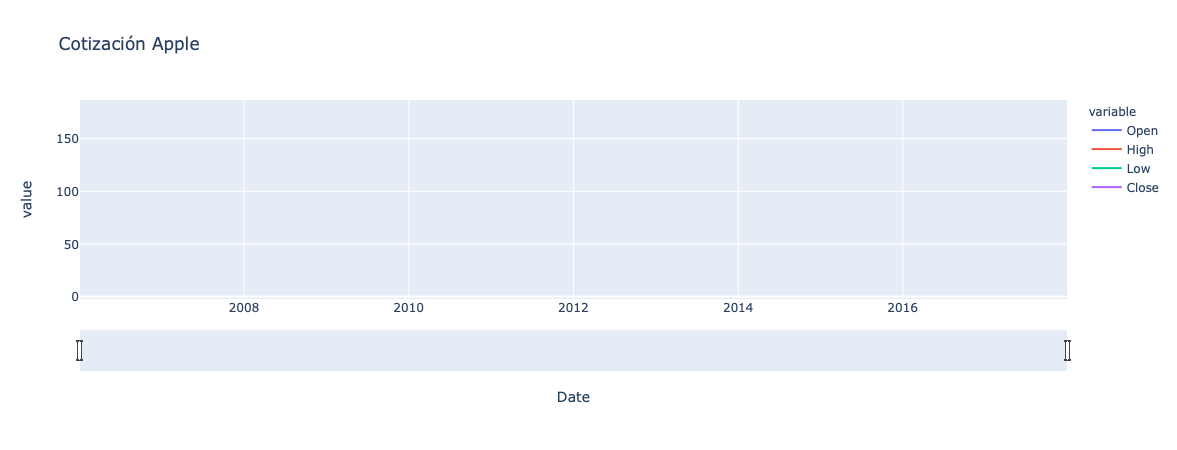

In [5]:
fig = px.line(df, x="Date", y=["Open",'High','Low','Close'],title='Cotización Apple')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Misma visualizacion pero esta vez con un gráfico de areas

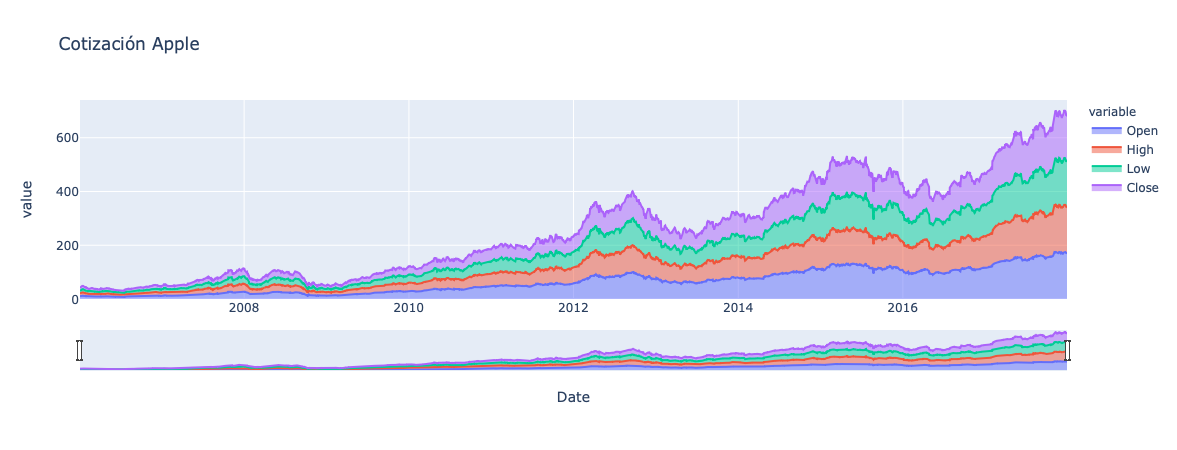

In [6]:
fig = px.area(df,x='Date',y=["Open",'High','Low','Close'], title='Cotización Apple')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Visualizacion mediante un gráfico de barras de la columna de diferencias entre apertura y cierre anteriormente introducida

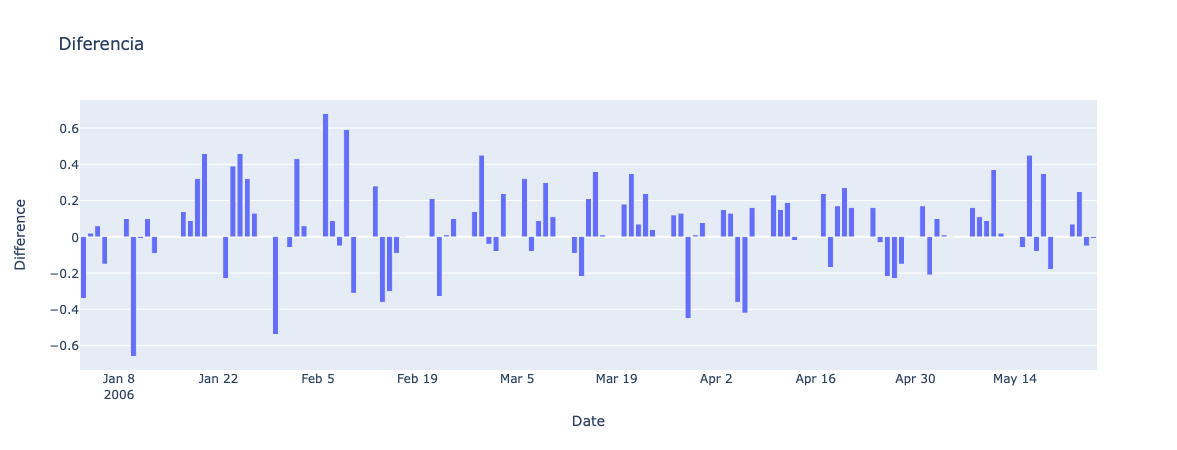

In [7]:
fig1=px.bar(df[0:100],x='Date',y='Difference',title='Diferencia')
fig1.show()

### Visualización de un gráfico OHLC de las primeras 100 fechas para obtener una mejor visualización, en este caso no se utiliza la versión simplificada de plotly, consta de 3 pasos: el trace, data y iplot que es el que activa la visulización

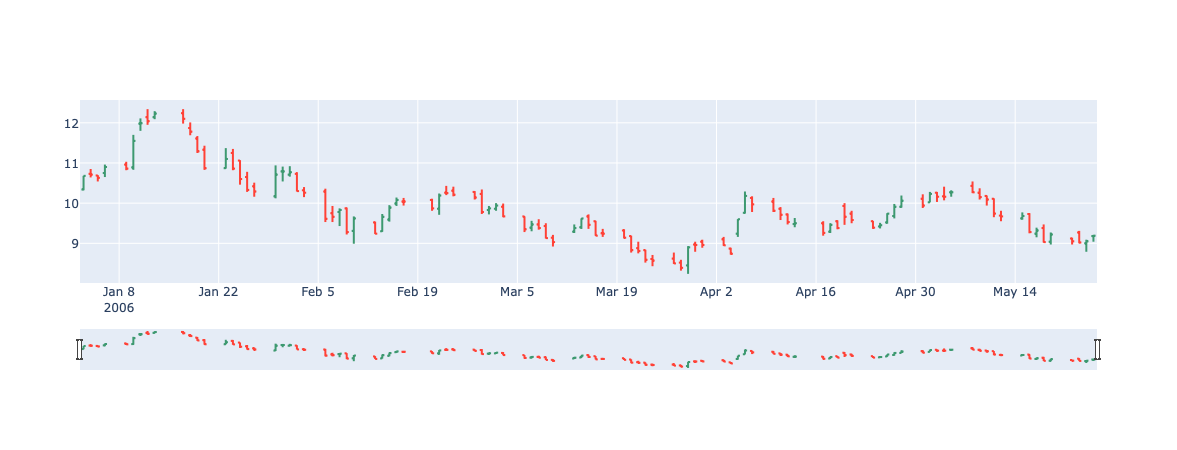

In [8]:
trace = go.Ohlc(x=df.Date[0:100],
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close,
               )

data = [trace]
iplot(data, filename='simple_ohlc')

### Misma visualización  que la anterior pero con un diagrama de velas

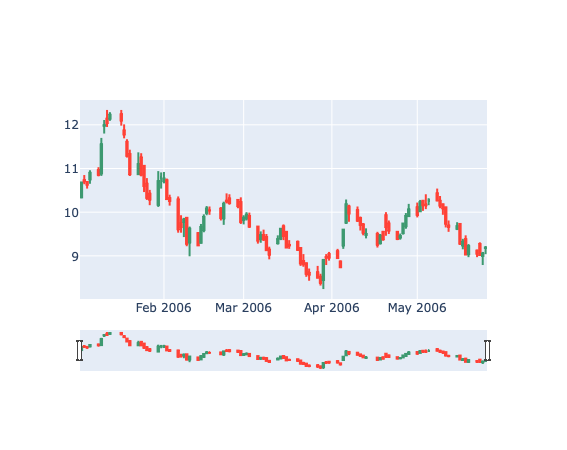

In [9]:
trace = go.Candlestick(x=df.Date[0:100],
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)
data = [trace]
iplot(data, filename='simple_candlestick')

### A continuación se va a hacer el preparado del dataset para ambos algoritmos:

En primer lugar te pide que el dataset que vaya a ser objeto de estudio conste de dos columnas; Una columna denominada "ds" que va a ser la columna temporal, en la documentación de ambos algoritmos te piden que sea formato datetime o datestamp y en modo anglosajon, es decir Year/Month/Day. La segunda columna se denominará "y" en ella se encontrará los datos que queremos predecir.

Procedemos a borrar las columnas innecesarias y renombrar las restantes

In [10]:
df.drop(['Open','High','Low','Volume','Name','Difference'],axis=1, inplace=True)

In [11]:
df.rename(columns={'Date':'ds','Close':'y'},inplace=True)

### El dataset resultante quedaría así

In [12]:
df

ds       y
0     2006-01-03   10.68
1     2006-01-04   10.71
2     2006-01-05   10.63
3     2006-01-06   10.90
4     2006-01-09   10.86
...          ...     ...
3014  2017-12-22  175.01
3015  2017-12-26  170.57
3016  2017-12-27  170.60
3017  2017-12-28  171.08
3018  2017-12-29  169.23

[3019 rows x 2 columns]

### Visualización del dataset

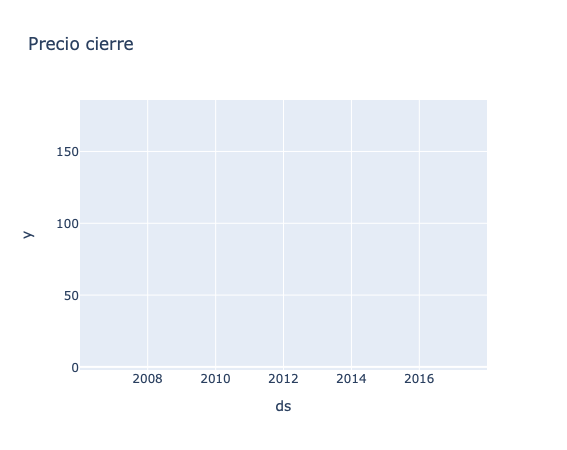

In [13]:
fig = px.line(df, x="ds", y="y",title='Precio cierre')
fig.show()

### A continuación separamos el dataset entre entrenamiento y prueba a partir de la fecha indicada en el código

In [14]:
test_length=df[df['ds']=='2016-12-30'].index[0]
df_train=df.iloc[:test_length]
df_test=df.iloc[test_length:]

In [15]:
df_train

ds       y
0     2006-01-03   10.68
1     2006-01-04   10.71
2     2006-01-05   10.63
3     2006-01-06   10.90
4     2006-01-09   10.86
...          ...     ...
2762  2016-12-22  116.29
2763  2016-12-23  116.52
2764  2016-12-27  117.26
2765  2016-12-28  116.76
2766  2016-12-29  116.73

[2767 rows x 2 columns]

In [16]:
df_test

ds       y
2767  2016-12-30  115.82
2768  2017-01-03  116.15
2769  2017-01-04  116.02
2770  2017-01-05  116.61
2771  2017-01-06  117.91
...          ...     ...
3014  2017-12-22  175.01
3015  2017-12-26  170.57
3016  2017-12-27  170.60
3017  2017-12-28  171.08
3018  2017-12-29  169.23

[252 rows x 2 columns]

## Elaboración del modelo

In [17]:
prophet_model=Prophet(daily_seasonality=True)
prophet_model.fit(df_train)
future_df=prophet_model.make_future_dataframe(periods=365)
forecast=prophet_model.predict(future_df)


### Dataframe de predicción 

In [18]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2006-01-03   10.275192    2.237766   16.203526    10.275192    10.275192   
1    2006-01-04   10.279586    1.621628   15.784598    10.279586    10.279586   
2    2006-01-05   10.283980    2.313556   15.799489    10.283980    10.283980   
3    2006-01-06   10.288375    1.571141   14.525211    10.288375    10.288375   
4    2006-01-09   10.301558    1.481013   15.404843    10.301558    10.301558   
...         ...         ...         ...         ...          ...          ...   
3127 2017-12-25  102.863986   81.531700  119.405410    85.375940   118.325047   
3128 2017-12-26  102.852054   83.013076  119.441025    85.237340   118.383135   
3129 2017-12-27  102.840121   81.815942  119.225081    85.098741   118.437313   
3130 2017-12-28  102.828189   82.018118  118.502661    84.963329   118.495657   
3131 2017-12-29  102.816256   80.636411  119.142890    84.831811   118.554001   

      additive_terms  additive_terms_lower  additive_terms_upper     daily  \
0          -1.673689             -1.673689             -1.673689 -1.025912   
1          -1.688827             -1.688827             -1.688827 -1.025912   
2          -1.744370             -1.744370             -1.744370 -1.025912   
3          -1.961854             -1.961854             -1.961854 -1.025912   
4          -2.057543             -2.057543             -2.057543 -1.025912   
...              ...                   ...                   ...       ...   
3127       -1.407488             -1.407488             -1.407488 -1.025912   
3128       -1.484178             -1.484178             -1.484178 -1.025912   
3129       -1.490204             -1.490204             -1.490204 -1.025912   
3130       -1.519852             -1.519852             -1.519852 -1.025912   
3131       -1.695146             -1.695146             -1.695146 -1.025912   

      ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0     ... -0.041000     -0.041000     -0.041000 -0.606777     -0.606777   
1     ... -0.015845     -0.015845     -0.015845 -0.647070     -0.647070   
2     ... -0.020646     -0.020646     -0.020646 -0.697811     -0.697811   
3     ... -0.175509     -0.175509     -0.175509 -0.760433     -0.760433   
4     ... -0.003479     -0.003479     -0.003479 -1.028152     -1.028152   
...   ...       ...           ...           ...       ...           ...   
3127  ... -0.003479     -0.003479     -0.003479 -0.378097     -0.378097   
3128  ... -0.041000     -0.041000     -0.041000 -0.417267     -0.417267   
3129  ... -0.015845     -0.015845     -0.015845 -0.448448     -0.448448   
3130  ... -0.020646     -0.020646     -0.020646 -0.473294     -0.473294   
3131  ... -0.175509     -0.175509     -0.175509 -0.493725     -0.493725   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0        -0.606777                   0.0                         0.0   
1        -0.647070                   0.0                         0.0   
2        -0.697811                   0.0                         0.0   
3        -0.760433                   0.0                         0.0   
4        -1.028152                   0.0                         0.0   
...            ...                   ...                         ...   
3127     -0.378097                   0.0                         0.0   
3128     -0.417267                   0.0                         0.0   
3129     -0.448448                   0.0                         0.0   
3130     -0.473294                   0.0                         0.0   
3131     -0.493725                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
0                            0.0    8.601503  
1                            0.0    8.590759  
2                            0.0    8.539611  
3                            0.0    8.326521  
4                            0.0    8.244015  
...                          ...         ...  
3127    

### Visualización de la predicción con plotly de prophet

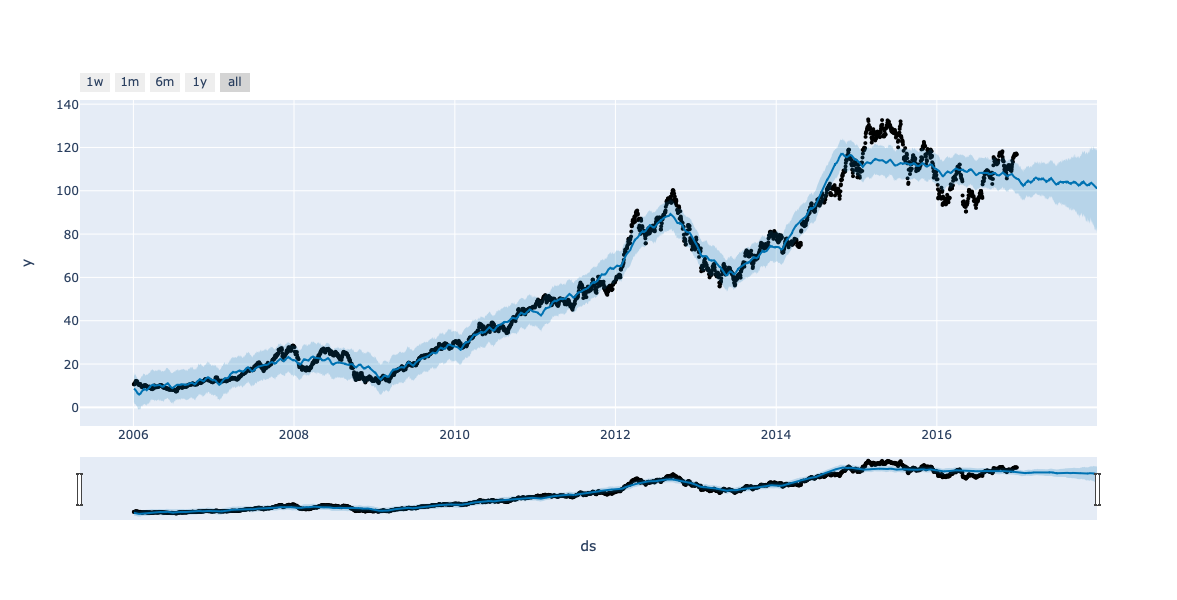

In [19]:
plot_plotly(prophet_model,forecast)

### Añadimos la columna de predicciones al dataframe de prueba

In [20]:
df_test['prophet'] = forecast.iloc[test_length:].loc[:,'yhat']

/Users/ismaelgarciainigo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
df_test

ds       y     prophet
2767  2016-12-30  115.82  105.441985
2768  2017-01-03  116.15  105.715361
2769  2017-01-04  116.02  105.682157
2770  2017-01-05  116.61  105.512144
2771  2017-01-06  117.91  105.429103
...          ...     ...         ...
3014  2017-12-22  175.01  103.510158
3015  2017-12-26  170.57  103.409433
3016  2017-12-27  170.60  103.411882
3017  2017-12-28  171.08  103.484809
3018  2017-12-29  169.23  103.534124

[252 rows x 3 columns]

### Visualización de las variables real y prediccion, como se puede observar la predriccion dista mucho de ser buena.

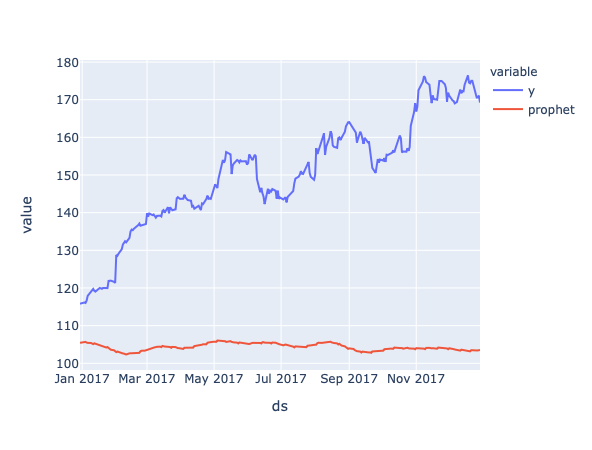

In [22]:
fig = px.line(df_test, x="ds", y=["y",'prophet'])
fig.show()

### Ploteo de los componentes con las gráficas de plotly del algoritmo prophet

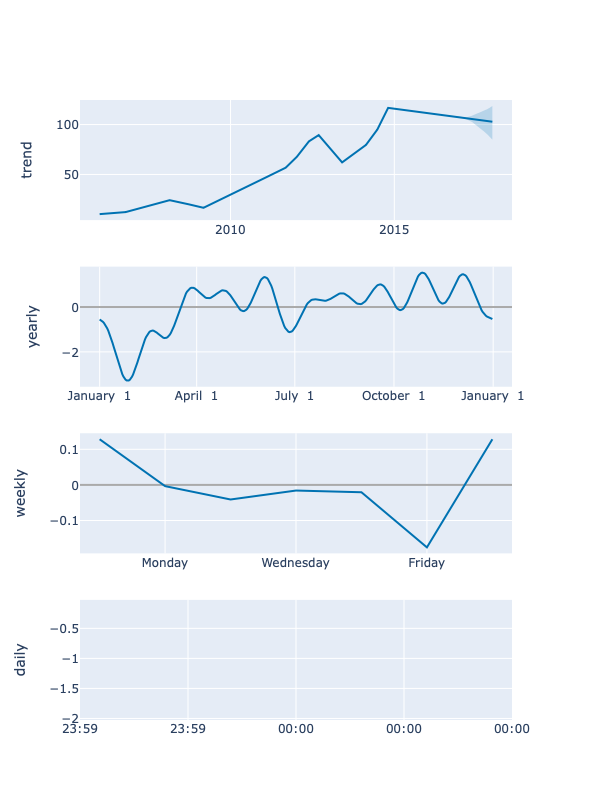

In [23]:
plot_components_plotly(prophet_model, forecast)

### Misma visualización pero con un ploteo no dináminco

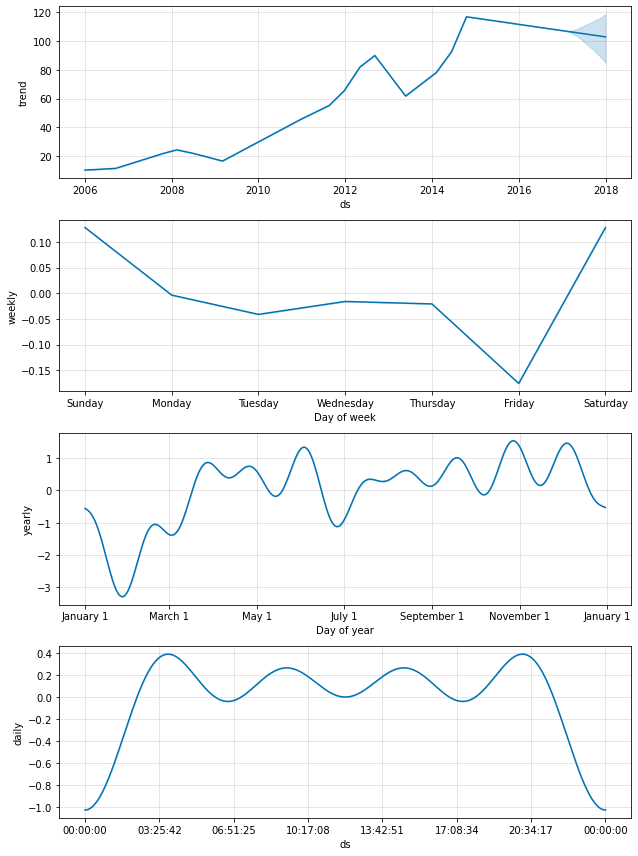

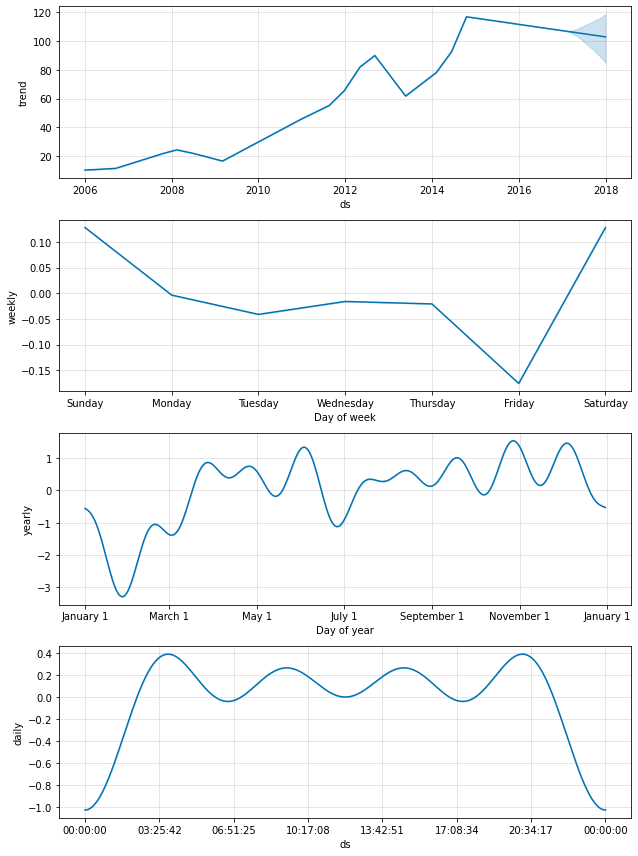

In [24]:
prophet_model.plot_components(forecast)

### A continuación hacemos una copia del dataframe para elaborar el modelo Neural Prophet

In [25]:
df1=df.copy()
df1

ds       y
0     2006-01-03   10.68
1     2006-01-04   10.71
2     2006-01-05   10.63
3     2006-01-06   10.90
4     2006-01-09   10.86
...          ...     ...
3014  2017-12-22  175.01
3015  2017-12-26  170.57
3016  2017-12-27  170.60
3017  2017-12-28  171.08
3018  2017-12-29  169.23

[3019 rows x 2 columns]

In [26]:
test_length=df1[df1['ds']=='2016-12-30'].index[0]
df_train1=df1.iloc[:test_length]
df_test1=df1.iloc[test_length:]

In [27]:
df_train1

ds       y
0     2006-01-03   10.68
1     2006-01-04   10.71
2     2006-01-05   10.63
3     2006-01-06   10.90
4     2006-01-09   10.86
...          ...     ...
2762  2016-12-22  116.29
2763  2016-12-23  116.52
2764  2016-12-27  117.26
2765  2016-12-28  116.76
2766  2016-12-29  116.73

[2767 rows x 2 columns]

### Codigo del modelo, es práticamente igual al antetior con la excepción de algunos parámetros con respecto al tiempo.

In [28]:
model1 = NeuralProphet()
metrics = model1.fit(df_train1, freq="D")
future = model1.make_future_dataframe(df_train1, periods = test_length, 
                                                 n_historic_predictions=len(df_train1))
forecast1 = model1.predict(future)

/Users/ismaelgarciainigo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 23
INFO:nprophet.config:Auto-set epochs to 23


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
INFO:nprophet:learning rate range test found optimal lr: 1.87E-01
Epoch[23/23]: 100%|██████████| 23/23 [00:03<00:00,  7.56it/s, SmoothL1Loss=0.00297, MAE=7.48, RegLoss=0]


### Visualización de la predicción, en este caso Neural Prophet no existe la posibilidad de hacer un ploteo dinámico dentro de la propia librería.

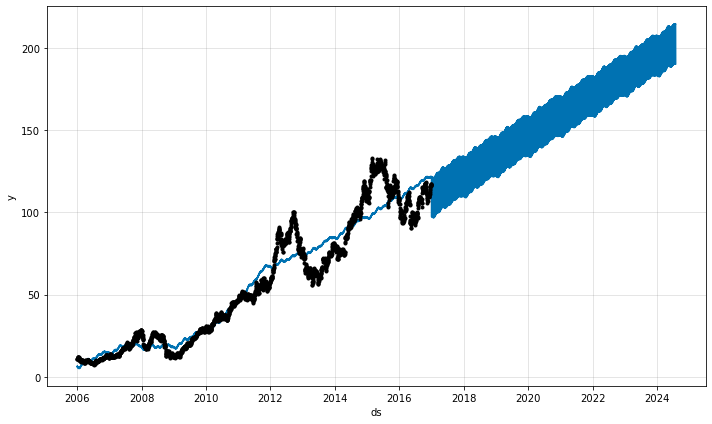

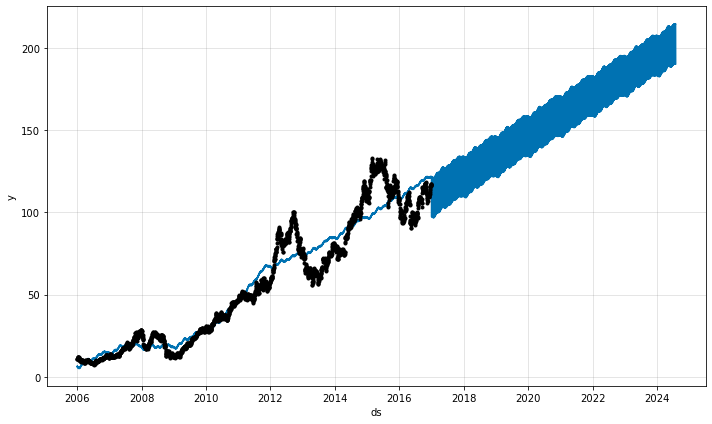

In [29]:
model1.plot(forecast1)

### Visualización de los componentes

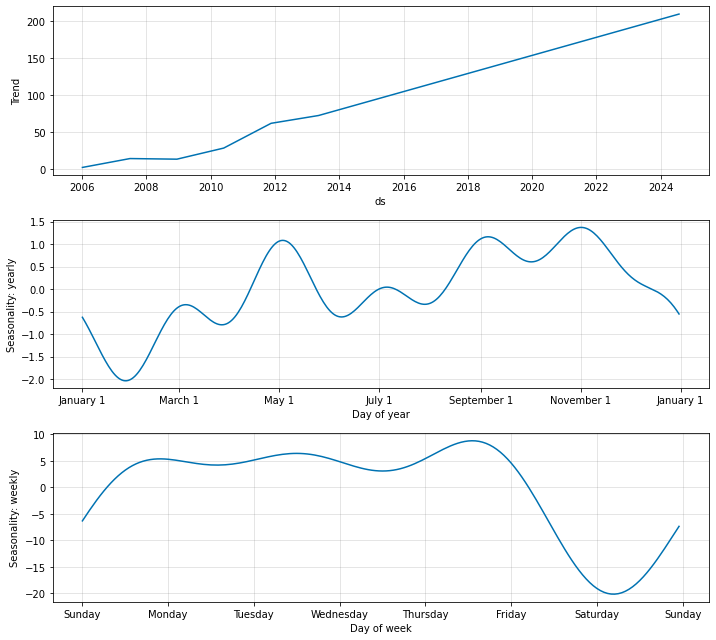

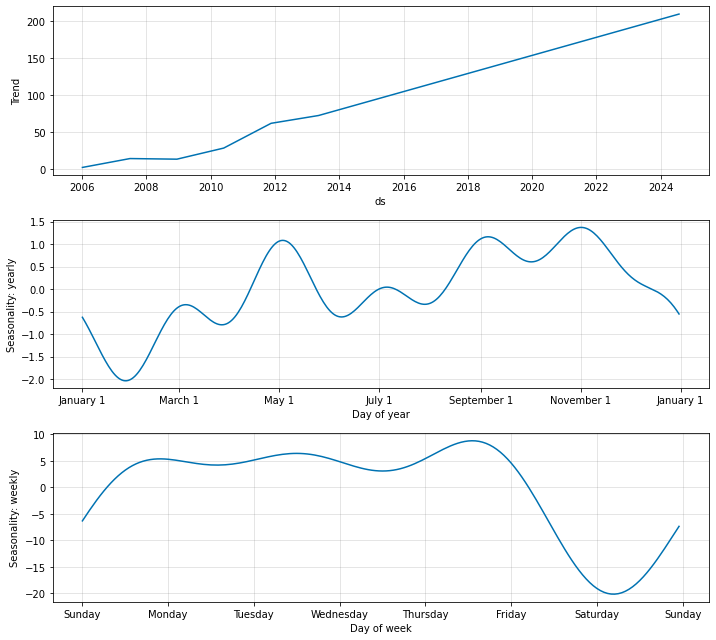

In [30]:
model1.plot_components(forecast1)

### Visualización de los parámetros

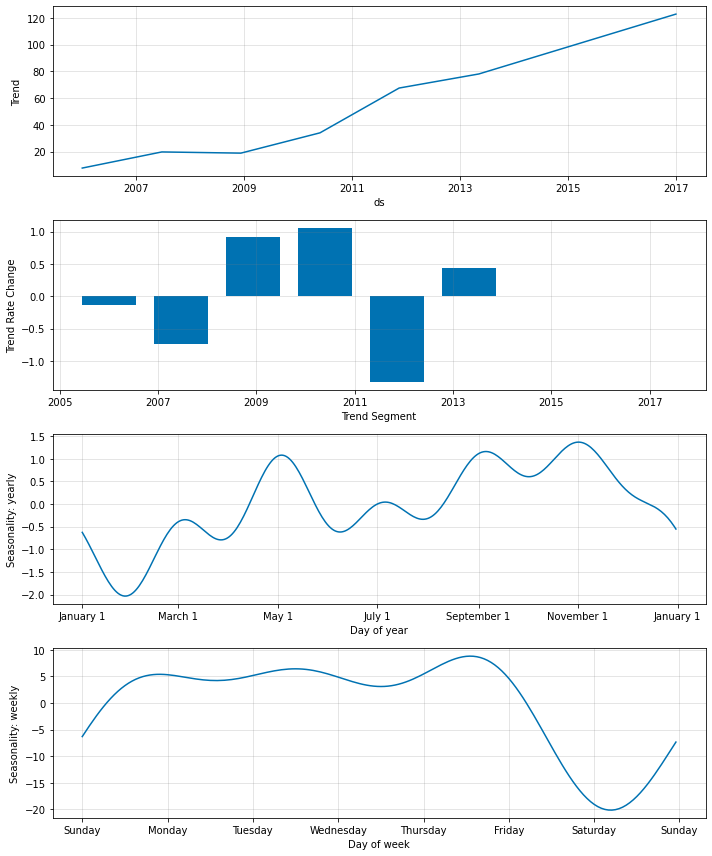

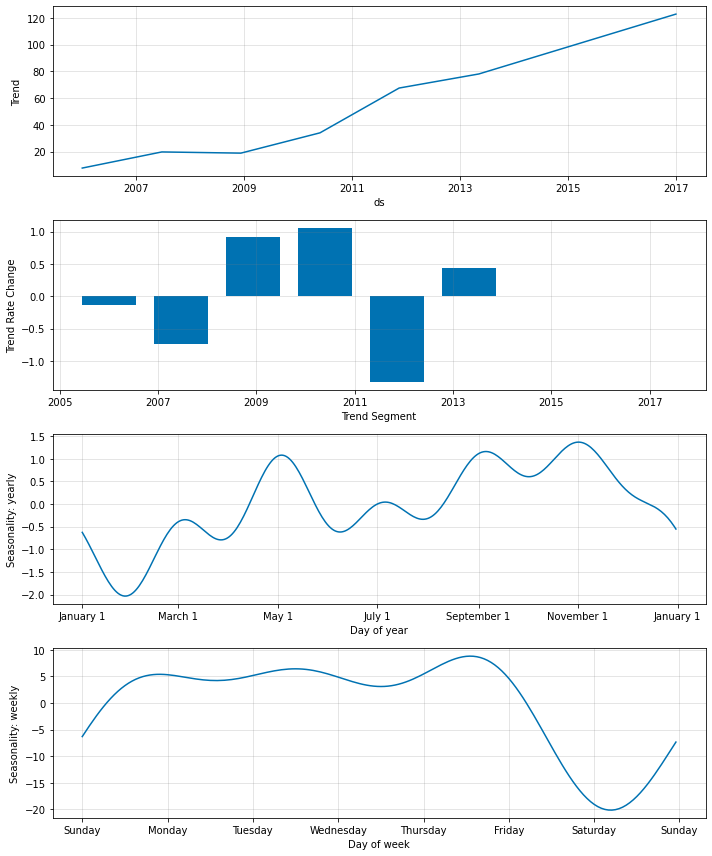

In [31]:
model1.plot_parameters()

### Dataframe de la predicción

In [32]:
forecast1

ds      y       yhat1  residual1       trend  season_yearly  \
0    2006-01-03  10.68    6.291806  -4.388194    1.863172      -0.735630   
1    2006-01-04  10.71    5.943231  -4.766769    1.885688      -0.801701   
2    2006-01-05  10.63    6.482429  -4.147571    1.908203      -0.869788   
3    2006-01-06  10.90    5.602207  -5.297793    1.930719      -0.939565   
4    2006-01-09  10.86    6.158556  -4.701444    1.998268      -1.155303   
...         ...    ...         ...        ...         ...            ...   
5529 2024-07-23    NaN  214.479980        NaN  209.596237      -0.280505   
5530 2024-07-24    NaN  214.191132        NaN  209.629776      -0.297892   
5531 2024-07-25    NaN  214.794846        NaN  209.663361      -0.312525   
5532 2024-07-26    NaN  213.983902        NaN  209.696915      -0.324057   
5533 2024-07-27    NaN  190.325607        NaN  209.730499      -0.332173   

      season_weekly  
0          5.164264  
1          4.859244  
2          5.444013  
3          4.611053  
4          5.315592  
...             ...  
5529       5.164264  
5530       4.859244  
5531       5.444013  
5532       4.611053  
5533     -19.072723  

[5534 rows x 7 columns]

### Añadimos los datos de la predicción en el dataframe de testeo

In [33]:
df_test['Neural Prophet']=forecast1.loc[:,'yhat1']

/Users/ismaelgarciainigo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
df_test

ds       y     prophet  Neural Prophet
2767  2016-12-30  115.82  105.441985      120.991096
2768  2017-01-03  116.15  105.715361       97.284645
2769  2017-01-04  116.02  105.682157      110.010345
2770  2017-01-05  116.61  105.512144      121.619080
2771  2017-01-06  117.91  105.429103      121.436966
...          ...     ...         ...             ...
3014  2017-12-22  175.01  103.510158      120.006996
3015  2017-12-26  170.57  103.409433      131.686752
3016  2017-12-27  170.60  103.411882      131.573471
3017  2017-12-28  171.08  103.484809      131.301956
3018  2017-12-29  169.23  103.534124      131.915817

[252 rows x 4 columns]

## Hacemos una visualización de las tres variables, real, con el algoritmo Prophet y con el algoritmo Neural Prophet, llegamos a la conclusión, la cual ya se sabía que no se puede elaborar un predicción de una acción en el mercado de valores.

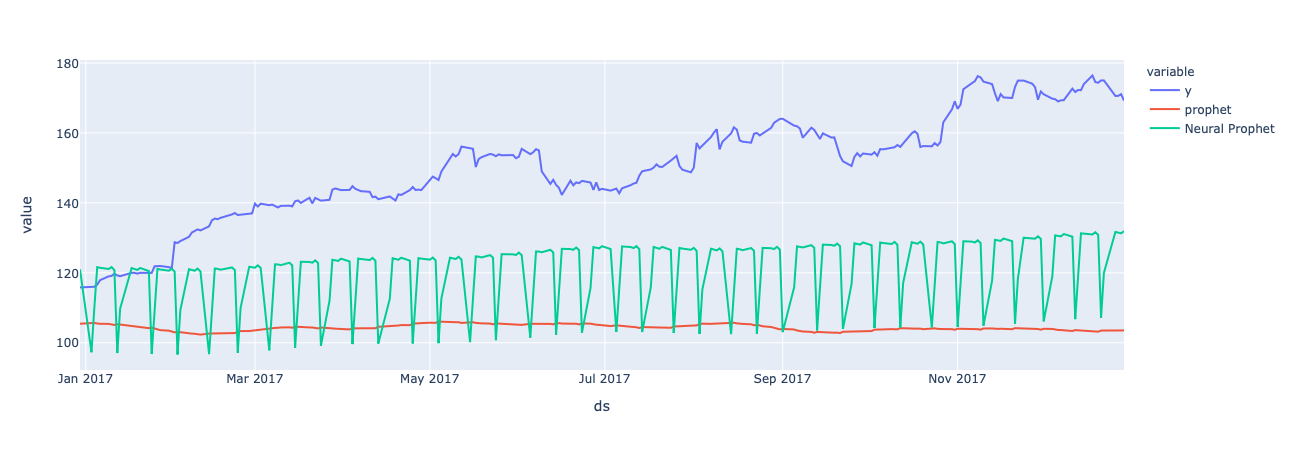

In [35]:
fig = px.line(df_test, x="ds", y=["y",'prophet','Neural Prophet'])
fig.show()